# Health Data in the US

* Data derived from Kaggle - 500 Cities: Local Data for Better Health
* No questions/problems within the Kaggle repository, and only one other notebook had been added to repository (on my own!!)
* Goal: determine if there is correlation between the different health measurements, and if there are any trends with location of the cities/regions

In [1]:
#getting and working with data
import pandas as pd
import scipy.stats as stats
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler, Normalizer
import numpy as np
from sklearn.metrics.cluster import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

#visualizing results
%matplotlib inline
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt

In [3]:
#attempting to utilize Geopy
from geopy.distance import great_circle
from math import radians, degrees, sin, cos, asin, acos, sqrt
def great_circle(pair1, pair2):
    
    lon1, lat1, lon2, lat2 = map(radians, [pair1[0], pair1[1], pair2[0], pair2[1]])
    return 6371 * (acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2)))

In [4]:
hd = pd.read_csv("kaggle_data/500_Cities__Local_Data_for_Better_Health__2018_release.csv")
hd.head()

,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,...,High_Confidence_Limit,Data_Value_Footnote_Symbol,Data_Value_Footnote,PopulationCount,Geolocation,CategoryID,MeasureId,CityFIPS,TractFIPS,Short_Question_Text
0,2015,IN,Indiana,Fishers,City,BRFSS,Health Outcomes,1823278,High blood pressure among adults aged >=18 Years,%,...,24.7,NaN,NaN,76794,POINT (-85.969310702 39.9587635263),HLTHOUT,BPHIGH,1823278.0,NaN,High Blood Pressure
1,2015,CA,California,Milpitas,City,BRFSS,Health Outcomes,0647766,High blood pressure among adults aged >=18 Years,%,...,22.5,NaN,NaN,66790,POINT (-121.892083025 37.433869763),HLTHOUT,BPHIGH,647766.0,NaN,High Blood Pressure
2,2015,CT,Connecticut,Stamford,City,BRFSS,Health Outcomes,0973000,High blood pressure among adults aged >=18 Years,%,...,26.2,NaN,NaN,122643,POINT (-73.5589363142 41.1049145013),HLTHOUT,BPHIGH,973000.0,NaN,High Blood Pressure
3,2015,CA,California,Elk Grove,City,BRFSS,Health Outcomes,0622020,High blood pressure among adults aged >=18 Years,%,...,27.8,NaN,NaN,153015,POINT (-121.384137762 38.4159992006),HLTHOUT,BPHIGH,622020.0,NaN,High Blood Pressure
4,2015,FL,Florida,Palm Bay,City,BRFSS,Prevention,1254000,Cholesterol screening among adults aged >=18 Y...,%,...,78.4,NaN,NaN,103190,POINT (-80.6666722846 27.9838255249),PREVENT,CHOLSCREEN,1254000.0,NaN,Cholesterol Screening


I should mention... no metadata made this dataset interesting to learn about... turns out there's several different populations per entry (whole city vs. subset, census tract etc), as well as geolocation points.

24 columns is a lot... which ones do we care about?

In [5]:
hd.columns

Index(['Year', 'StateAbbr', 'StateDesc', 'CityName', 'GeographicLevel',
       'DataSource', 'Category', 'UniqueID', 'Measure', 'Data_Value_Unit',
       'DataValueTypeID', 'Data_Value_Type', 'Data_Value',
       'Low_Confidence_Limit', 'High_Confidence_Limit',
       'Data_Value_Footnote_Symbol', 'Data_Value_Footnote', 'PopulationCount',
       'Geolocation', 'CategoryID', 'MeasureId', 'CityFIPS', 'TractFIPS',
       'Short_Question_Text'],
      dtype='object')

In [6]:
#here is where i'm going to drop columns i don't want
hd2 = hd.drop(['Year','DataSource','Data_Value_Footnote_Symbol', 'Data_Value_Footnote','CityFIPS', 'TractFIPS', 'GeographicLevel', 'Category', 'CategoryID', 'Measure', 'Low_Confidence_Limit', 'High_Confidence_Limit',
       'Data_Value_Footnote_Symbol', 'DataValueTypeID', 'MeasureId',
       'Data_Value_Type','Data_Value_Footnote','CityFIPS', 'TractFIPS','CategoryID','Data_Value_Unit','UniqueID'], axis=1)

In [7]:
#see how the data looks now
hd2.head()

,StateAbbr,StateDesc,CityName,Data_Value,PopulationCount,Geolocation,Short_Question_Text
0,IN,Indiana,Fishers,24.2,76794,POINT (-85.969310702 39.9587635263),High Blood Pressure
1,CA,California,Milpitas,22.2,66790,POINT (-121.892083025 37.433869763),High Blood Pressure
2,CT,Connecticut,Stamford,26.0,122643,POINT (-73.5589363142 41.1049145013),High Blood Pressure
3,CA,California,Elk Grove,27.7,153015,POINT (-121.384137762 38.4159992006),High Blood Pressure
4,FL,Florida,Palm Bay,78.0,103190,POINT (-80.6666722846 27.9838255249),Cholesterol Screening


Eventually we'll look at Geographic data... turn that Geolocation into Latitude and Longitude columns

In [41]:
#clean up Geolocation to seperate into two features, Latitude and Longitude
hd2["Coordinates"] = hd2.Geolocation.str.slice(7,-2) #starting at character 8 removes POINT ()
#convert coordinates into Latitude and Longitude
hd2[['Latitude', 'Longitude']] = hd2.Coordinates.str.split(' ', expand=True)
#remove Coordinates and Geolocation feature - keep it clean!
hd3 = hd2.drop(["Geolocation", "Coordinates"], axis=1)
hd3.head()

,StateAbbr,StateDesc,CityName,Data_Value,PopulationCount,Short_Question_Text,Latitude,Longitude
0,IN,Indiana,Fishers,24.2,76794,High Blood Pressure,-85.969310702,39.958763526
1,CA,California,Milpitas,22.2,66790,High Blood Pressure,-121.892083025,37.43386976
2,CT,Connecticut,Stamford,26.0,122643,High Blood Pressure,-73.5589363142,41.104914501
3,CA,California,Elk Grove,27.7,153015,High Blood Pressure,-121.384137762,38.415999200
4,FL,Florida,Palm Bay,78.0,103190,Cholesterol Screening,-80.6666722846,27.983825524


I attempted to write a function to define the quadrant based off Latitude and Longitude, but will return to this at a later time:

In [32]:
#add new feature that determines where in the US the city is (Northeast, Southeast, NorthWest, SouthWest)
# center of US 39.82832929826687, -98.57947447532929
Midlat = 39.82832929826687
Midlong = -98.57947447532929
Q = ['Northeast' , 'Southeast' , 'Northwest','Southwest']
def Quadrantcalc (x):
    if hd4['Latitude']>Midlat and hd4['Longitude']>Midlong:
        x = 'Northeast'
    elif hd4['Latitude']<Midlat and hd4['Longitude']>Midlong:
        x = 'Southeast'
    elif hd4['Latitude']>Midlat and hd4['Longitude']<Midlong:
        x = 'Northwest'
    elif hd4['Latitude']<Midlat and hd4['Longitude']<Midlong:
        x = 'Southwest'
    return Quadrant
hd4['Quadrant'] = hd4.apply(Quadrant)
hd4.head()

NameError: name 'Quadrant' is not defined

Add in Region, the Quadrant classifier may not be that great:

In [10]:
#Quadrant is ok, but here is a regions file that's better suited to the data by state 
regions = pd.read_csv("kaggle_data/US_Regions.csv")

In [38]:
#this is where i'm going to join the two datasets
hd4 = hd3.merge(regions, on='StateDesc')
hd4['Latitude'].astype(str)
hd4['Longitude'].astype(str)
hd4.head()

,StateAbbr,StateDesc,CityName,Data_Value,PopulationCount,Short_Question_Text,Latitude,Longitude,Region
0,IN,Indiana,Fishers,24.2,76794,High Blood Pressure,-85.969310702,39.958763526,Midwest
1,IN,Indiana,Evansville,41.6,2575,Obesity,-87.5504740243,37.98983091,Midwest
2,IN,Indiana,South Bend,15.1,101168,Mental Health,-86.2690372417,41.676991454,Midwest
3,IN,Indiana,Indianapolis,29.0,4020,High Blood Pressure,-86.1478857314,39.729250055,Midwest
4,IN,Indiana,Muncie,3.4,70085,Stroke,-85.3942940148,40.198709832,Midwest


Random pairplot to see if there was any visible trends, but there's way too much data:

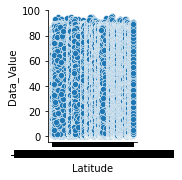

In [40]:
sns.pairplot(hd4, x_vars='Latitude', y_vars='Data_Value')

What are the health measures, anyways?

In [45]:
hd3.Short_Question_Text.unique()

array(['High Blood Pressure', 'Cholesterol Screening', 'Arthritis',
       'Stroke', 'Obesity', 'Mammography', 'Teeth Loss', 'Diabetes',
       'Binge Drinking', 'Cancer (except skin)', 'Mental Health', 'COPD',
       'Current Smoking', 'Coronary Heart Disease', 'Pap Smear Test',
       'Current Asthma', 'Sleep <7 hours', 'Dental Visit',
       'Chronic Kidney Disease', 'Health Insurance',
       'Taking BP Medication', 'High Cholesterol', 'Annual Checkup',
       'Core preventive services for older women', 'Physical Health',
       'Colorectal Cancer Screening',
       'Core preventive services for older men', 'Physical Inactivity'],
      dtype=object)

28 measures is a lot, grab a sample of 7 of them to look at for now. There may be a better way to unstack this data, but ran a `.groupby()` function to pull out the (semi-random) sample. Used the mean of cityname values and it's attributing region:

In [12]:
Sleep = hd4[hd4.Short_Question_Text == 'Sleep <7 hours']
Sleep1 = Sleep[['StateDesc', 'Data_Value']].groupby(['StateDesc']).mean()
Sleep1.rename(columns={'Data_Value': 'Sleep_<7_hours'}, inplace=True)

Stroke = hd4[hd4.Short_Question_Text == 'Stroke']
Stroke1 = Stroke[['StateDesc', 'Data_Value']].groupby(['StateDesc']).mean()
Stroke1.rename(columns={'Data_Value': 'Stroke'}, inplace=True)      

Binge = hd4[hd4.Short_Question_Text == 'Binge Drinking']
Binge1 = Binge[['StateDesc', 'Data_Value']].groupby(['StateDesc']).mean()
Binge1.rename(columns={'Data_Value': 'Binge_Drinking'}, inplace=True)           

MH = hd4[hd4.Short_Question_Text == 'Mental Health']
MH1 = MH[['StateDesc', 'Data_Value']].groupby(['StateDesc']).mean()
MH1.rename(columns={'Data_Value': 'Mental_Health'}, inplace=True)           

Smoke = hd4[hd4.Short_Question_Text == 'Current Smoking']
Smoke1 = Smoke[['StateDesc', 'Data_Value']].groupby(['StateDesc']).mean()
Smoke1.rename(columns={'Data_Value': 'Current_Smoking'}, inplace=True)           

Phys = hd4[hd4.Short_Question_Text == 'Physical Inactivity']
Phys1 = Phys[['StateDesc', 'Data_Value']].groupby(['StateDesc']).mean()
Phys1.rename(columns={'Data_Value': 'Physical_Inactivity'}, inplace=True)           

HBP = hd4[hd4.Short_Question_Text == 'High Blood Pressure']
HBP1 = HBP[['StateDesc', 'Data_Value']].groupby(['StateDesc']).mean()
HBP1.rename(columns={'Data_Value': 'High_Blood_Pressure'}, inplace=True)           

SS = pd.concat([Sleep1,Stroke1,Binge1,MH1,Smoke1,Phys1,HBP1], axis=1)
SS.reset_index(level=None)
SS = pd.merge(SS,regions, on='StateDesc')
SS.head()



,StateDesc,Sleep_<7_hours,Stroke,Binge_Drinking,Mental_Health,Current_Smoking,Physical_Inactivity,High_Blood_Pressure,Region
0,Alabama,39.096639,4.177871,14.754622,14.366947,20.420728,29.847619,40.003922,South
1,Alaska,31.268421,2.296491,19.294737,11.373684,18.070175,17.615789,27.101754,Pacific
2,Arizona,35.537891,2.894434,16.724512,12.979004,17.246289,23.416895,27.579199,Southwest
3,Arkansas,35.618750,3.352344,15.385938,15.166406,22.079687,30.439062,35.117969,South
4,California,35.421383,2.702317,17.379456,12.268382,13.953330,21.287210,26.870608,Pacific


basic correlation matrix and heatmap to assess:

In [13]:
SS.corr()

,Sleep_<7_hours,Stroke,Binge_Drinking,Mental_Health,Current_Smoking,Physical_Inactivity,High_Blood_Pressure
Sleep_<7_hours,1.000000,0.715499,-0.437018,0.592190,0.519117,0.748235,0.734725
Stroke,0.715499,1.000000,-0.452115,0.732611,0.816097,0.797507,0.910757
Binge_Drinking,-0.437018,-0.452115,1.000000,-0.528240,-0.240020,-0.534327,-0.542621
Mental_Health,0.592190,0.732611,-0.528240,1.000000,0.675873,0.704188,0.651441
Current_Smoking,0.519117,0.816097,-0.240020,0.675873,1.000000,0.695193,0.763265
Physical_Inactivity,0.748235,0.797507,-0.534327,0.704188,0.695193,1.000000,0.777191
High_Blood_Pressure,0.734725,0.910757,-0.542621,0.651441,0.763265,0.777191,1.000000


<AxesSubplot:>

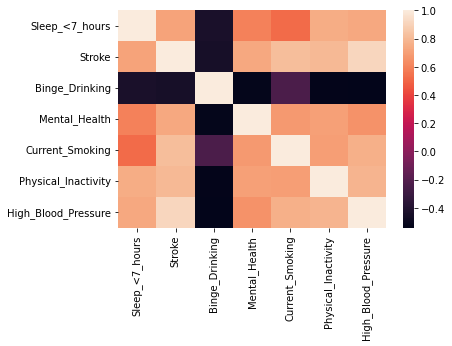

In [14]:
sns.heatmap(SS.corr())

Visualization time: lets see how this looks:

(Note: I tried setting a hue on this data, getting an error - going to investigate)

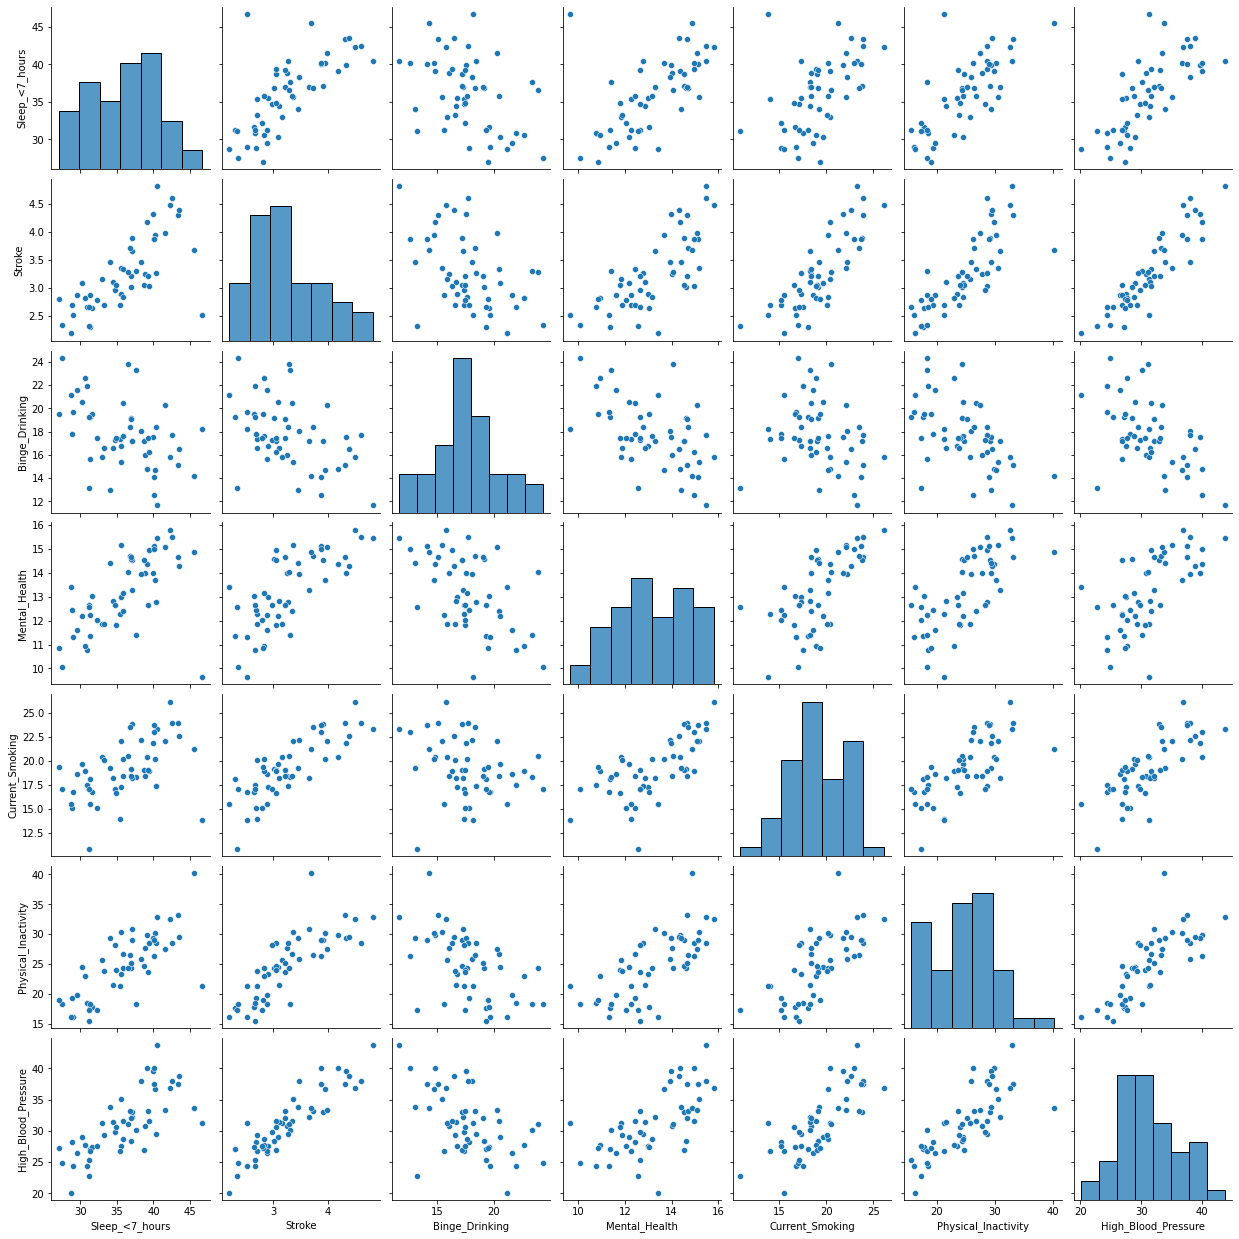

In [15]:
#having issues setting a hue to this pairplot - to be investigated
sns.pairplot(SS)

The binge drinking data is the only one that is negatively correlated, getting a better look at it:

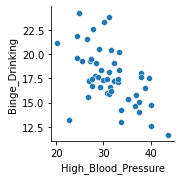

In [36]:
sns.pairplot(SS, x_vars='High_Blood_Pressure', y_vars='Binge_Drinking')#, hue='Region')

# Linear Regression Time

Basic linear regression on two random variables, High Blood pressure and stroke, just to get a feel of how the data looks (and if it works):

In [17]:
# create X and y
feature_cols = ['High_Blood_Pressure']
X = SS[feature_cols]
y = SS.Stroke
##FYI - should have removed spaces in feature names to make this a bit easier...

# instantiate and fit
acc_linreg = LinearRegression()
acc_linreg.fit(X, y)

# print the coefficients
print("The y intercept:", acc_linreg.intercept_)
print("The single coefficient:", acc_linreg.coef_)

The y intercept: -0.4250574761945569
The single coefficient: [0.11807194]


### Multiple Regression

* Running a regression on all measures except HBP, to see how well the model works. I'm sure there are more parameters I could add to better fit the model...

In [19]:
all_X = SS[SS.columns.tolist()[1:-2]]
all_y = SS.High_Blood_Pressure

all_linreg = LinearRegression()
all_linreg.fit(all_X,all_y)

all_pred = all_linreg.predict(all_X)

print("Full linear regression model r^2: ",metrics.r2_score(all_y,all_pred))

#For future, should we take out Binge drinking given the (surprisingly) negative correlation?

Full linear regression model r^2:  0.8809870935466031


## This concludes finalized cells
### Next Steps
    **show clustering by regions in pairplots and predictions based off regions

    **Figure out why Binge Drinking Data is negatively correlated - seems suspicious

    **Geographic visualization

    **hierarchical clustering??
    
    **incremental datasets that could be joined on (income, other geographic, other timesets (this was only 2015))?


Fin

### Class notes:
* Check census data
* weighted average if aggregating on states
* UniqueID - use this to match up state, region, lat/long etc.

Thank you all!!!

In [35]:
Midlat = 39.82832929826687
Midlong = -98.57947447532929
hd4['Quadrant'] = hd4['Quadrant'].apply(lambda Quadrant: 'Northeast' if hd4['Latitude']>Midlat and hd4['Longitude']>Midlong elif Quadrant: 'Southeast' if hd4['Latitude']<Midlat and hd4['Longitude']>Midlong elif Quadrant: 'Northwest' if hd4['Latitude']>Midlat and hd4['Longitude']<Midlong else 'Southwest', axis=1)

SyntaxError: invalid syntax (Temp/ipykernel_3680/1341046875.py, line 3)

In [70]:
#unstack pre-written but doesn't have the other columns
hd_measures0 = hd3[['Data_Value', 'CityName', 'StateDesc', 'Short_Question_Text']].groupby(['CityName', 'Short_Question_Text'])[['Data_Value']].mean().unstack('Short_Question_Text')
hd_measures0.head()

Data_Value                                      \
Short_Question_Text Annual Checkup  Arthritis Binge Drinking      COPD   
CityName                                                                 
Abilene                  66.379487  24.097436      17.771795  6.856410   
Akron                    74.526471  29.817647      14.911765  9.852941   
Alameda                  67.488889  18.555556      17.572222  4.300000   
Albany                   76.470909  25.327273      15.200000  7.743636   
Albuquerque              60.378417  24.920863      15.394964  5.443165   

                                                                \
Short_Question_Text Cancer (except skin) Cholesterol Screening   
CityName                                                         
Abilene                         5.748718             67.828205   
Akron                           6.113235             69.414706   
Alameda                         5.961111             79.422222   
Albany                          5.405455             71.512727   
Albuquerque                     5.850360             71.535971   

                                                                        \
Short_Question_Text Chronic Kidney Disease Colorectal Cancer Screening   
CityName                                                                 
Abilene                           3.030769                   56.181579   
Akron                             3.504412                   55.967647   
Alameda                           2.411111                   71.250000   
Albany                            3.329091                   62.681818   
Albuquerque                       2.897842                   59.076259   

                                                            \
Short_Question_Text Core preventive services for older men   
CityName                                                     
Abilene                                          31.710526   
Akron                                            24.517647   
Alameda                                          36.205556   
Albany                                           30.767273   
Albuquerque                                      40.679856   

                                                              ...              \
Short_Question_Text Core preventive services for older women  ... Mammography   
CityName                                                      ...               
Abilene                                            30.432432  ...   75.800000   
Akron                                              25.119118  ...   76.204412   
Alameda                                            35.200000  ...   79.011111   
Albany                                             27.683636  ...   82.100000   
Albuquerque                                        28.633813  ...   74.364029   

                                                                             \
Short_Question_Text Mental Health    Obesity Pap Smear Test Physical Health   
CityName                                                                      
Abilene                 13.587179  34.879487      80.133333       13.576923   
Akron                   15.920588  36.561765      82.622059       15.742647   
Alameda                  9.827778  18.633333      81.827778        9.361111   
Albany                  14.883636  35.565455      84.305455       14.163636   
Albuquerque             12.456835  27.592806      83.445324       12.816547   

                                                                  \
Short_Question_Text Physical Inactivity Sleep <7 hours    Stroke   
CityName                                                           
Abilene                       28.812821      33.446154  3.310256   
Akron                         33.466176      43.417647  4.394118   
Alameda                       16.277778      33.777778  2.261111   
Albany                        31.516364      42.883636  4.167273   
Albuquerque                   18.541727      32.131655

In [82]:
hd_measures9 = hd_measures0.reset_index()
hd_measures9.head()

CityName     Data_Value                            \
Short_Question_Text              Annual Checkup  Arthritis Binge Drinking   
0                        Abilene      66.379487  24.097436      17.771795   
1                          Akron      74.526471  29.817647      14.911765   
2                        Alameda      67.488889  18.555556      17.572222   
3                         Albany      76.470909  25.327273      15.200000   
4                    Albuquerque      60.378417  24.920863      15.394964   

                                                                          \
Short_Question_Text      COPD Cancer (except skin) Cholesterol Screening   
0                    6.856410             5.748718             67.828205   
1                    9.852941             6.113235             69.414706   
2                    4.300000             5.961111             79.422222   
3                    7.743636             5.405455             71.512727   
4                    5.443165             5.850360             71.535971   

                                                                        \
Short_Question_Text Chronic Kidney Disease Colorectal Cancer Screening   
0                                 3.030769                   56.181579   
1                                 3.504412                   55.967647   
2                                 2.411111                   71.250000   
3                                 3.329091                   62.681818   
4                                 2.897842                   59.076259   

                                                            ...              \
Short_Question_Text Core preventive services for older men  ... Mammography   
0                                                31.710526  ...   75.800000   
1                                                24.517647  ...   76.204412   
2                                                36.205556  ...   79.011111   
3                                                30.767273  ...   82.100000   
4                                                40.679856  ...   74.364029   

                                                                             \
Short_Question_Text Mental Health    Obesity Pap Smear Test Physical Health   
0                       13.587179  34.879487      80.133333       13.576923   
1                       15.920588  36.561765      82.622059       15.742647   
2                        9.827778  18.633333      81.827778        9.361111   
3                       14.883636  35.565455      84.305455       14.163636   
4                       12.456835  27.592806      83.445324       12.816547   

                                                                  \
Short_Question_Text Physical Inactivity Sleep <7 hours    Stroke   
0                             28.812821      33.446154  3.310256   
1                             33.466176      43.417647  4.394118   
2                             16.277778      33.777778  2.261111   
3                             31.516364      42.883636  4.167273   
4                             18.541727      32.131655  2.838129   

                                                     
Short_Question_Text Taking BP Medication Teeth Loss  
0                              72.717949  17.150000  
1                              77.529412  24.185294  
2                              71.055556   7.977778  
3                              72.838182  21.900000  
4                              70.409353  13.079137  

[5 rows x 29 columns]